# The Airbnb short staying rental data exploratory analysis and price prediction, a case study of Beijing<br>


### Programming Tools for Urban Analytics, Univeristy of Glasgow
##### Student ID: 2516202
##### 29 March 2021

## 1. Introduction
Under the background of massive tourism, the term "short staying" is popular with the development of e-commerce torisim in China. Airbnb offically entered Chinese home-sharing market in March 2017 (Airbnb, 2019), and is an online platform for short-term home and apartment rentals. China is one of the biggest markets for Airbnb in the world, and can be its largest potential market by 2021 (Zhang and Fu, 2020). Therefore, it is necessary to understand the consumers' rental experience and preference in the sharing economy in China. 

From the perspective of internet big data, short staying rental is becoming a bridge and driving force for the evolution of tourism accommodation industry. One challenge that Airbnb rental landlods face is determining the approporiate rent price. In many areas, renters are presented with a good selection of listings and can filter by criteria such as price, number of bedrooms, room type, rent periods and so on. Since Airbnb is an online market, the price a landlord set is ultimately tied to market price. Thus, this report aims to explore Airbnb guests' rental experience and preference in Beijing by using exploratory data analysis (EDA) and machine learning to analysis short staying rental price and discuss the feature importance.

This data science report mainly contains: 1) the data of rental price, geographical location, reviews and other data in various regions of Beijing, and 2) uses Lasso, Ridge, ElasticNet, and Linear Regression models for rental price prediction machine learning.

## 2. Data
Airbnb does not release any data from its website, but [Inside Airbnb](http://insideairbnb.com/), an watchdog website launched by Murray Cox in 2016, reports and scrapes data on the property rental marketplace company Airbnb, For this report, the data set was scraped on 22 Feburary, 2021, on the city of Beijing, China (Source: http://insideairbnb.com/get-the-data.html). It contains information on all Beijing Airbnb listings. 
### 2.1 Data overview

This section will process 'listings_detailed' data set and check the data information for the followed up (EDA) and machine learning sections. From the data head, we can see that the data set mostly contains numeric type variables such as price, longitude, latitude, number of reviews etc. However, some variables such as property type, neighbourhood_cleansed are text variables. There are 74 categories and 24977 observations in total for listings_detailed data set.

In [1]:
%matplotlib inline

import re
import jieba
import folium
import random
import wordcloud
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from folium.plugins import HeatMap
from IPython.display import Image
from scipy.special import jn
from scipy.stats import norm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from wordcloud import WordCloud, ImageColorGenerator
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False


listings_detailed = pd.read_csv('/Volumes/Ying/Salmon/UofG/Semester2/PTUA/Assignment/PythonA/Data/Feb2021/listings_detailed.csv')

In [2]:
#Use float for all numbers 
pd.set_option('display.float_format', lambda x: '%.2f' % x)

#Check the variable information of lisitings_detailed data set
listings_detailed.head(3)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,114384,https://www.airbnb.com/rooms/114384,20210200000000.00,24/02/2021,CBD Luxury 1-bedroom suite with a 30m2 terrace,Located in the core position of Chaoyang CBD. ...,NaN,https://a0.muscache.com/pictures/ab6e7489-562e...,533062,https://www.airbnb.com/users/show/533062,...,10.00,10.00,10.00,NaN,t,5,5,0,0,0.57
1,114465,https://www.airbnb.com/rooms/114465,20210200000000.00,26/02/2021,国贸CBD中国尊梵悦108附近豪华总统套房睡3人/步行五分钟至地铁站万达广场沃尔玛,中式装修搭配具有年代感的古董家具，<br />尽显东方美韵的同时又不失现代时尚。<br />...,"Walking distance to dozens of bus lines, Guoma...",https://a0.muscache.com/pictures/miso/Hosting-...,533062,https://www.airbnb.com/users/show/533062,...,10.00,10.00,9.00,NaN,t,5,5,0,0,0.12
2,627240,https://www.airbnb.com/rooms/627240,20210200000000.00,23/02/2021,Culturally Inspired @ City Center,<b>The space</b><br />As you can see from the ...,NaN,https://a0.muscache.com/pictures/8814001/0f63a...,3113849,https://www.airbnb.com/users/show/3113849,...,10.00,10.00,10.00,NaN,f,1,0,1,0,0.01


In [3]:
# check the data set size
print('"listings_detailed" shape: %d, categories: %d' %(listings_detailed.shape[0], listings_detailed.shape[1]))

"listings_detailed" shape: 24977, categories: 74


### 2.2 Data processing
The data set used for this report from Inside Airbnb is web scraping data, it may contain some invalid variables which are irrelevant to price prediction. In terms of detailed data set, free text columns were dropped as well as other features not useful for predicting price (e.g. host_url, host_about, and other host-related features that are unrelated to the property). There were repeated columns for minimum and maximum night stays, were few differences between minimum_maximum_nights, minimum_minimum_nights etc. In addtion, the descriptive variable, such as neighbourhood_overview (the overview of the room address features), can be reflected by latitude and longitude, as the HeatMap showed in section 4 below. Other NA variables such as license, neighbourhood_group_cleansed, bathrooms, calendar_updated etc can be discarded as well. In addtion, due to all of the listings being located in Beijing, the host_location column was dropped. After pre-data processing, there are 36 vairables will be used for exploratory data analysis.

In [4]:
listings_data = listings_detailed

In [5]:

# drop the irrelevant variables for listings_detailed
listings_detailed = listings_detailed.drop([
    'name', 'description', 'id', 
    'scrape_id', 
    'last_scraped', 
    'picture_url', 'listing_url', 
    'calendar_updated',
    'calendar_last_scraped',
    'neighbourhood',
    'neighborhood_overview', 
    'neighbourhood_group_cleansed',
    'host_thumbnail_url', 'host_picture_url', 
    'host_location', 'host_about', 
    'host_name','host_since', 
    'host_id', 'host_url',
    'host_response_time', 
    'host_neighbourhood', 
    'host_verifications', 
    'host_total_listings_count', 
    'host_acceptance_rate',
    'first_review',
    'last_review', 
    'number_of_reviews_l30d',
    'number_of_reviews_ltm',
    'reviews_per_month',
    'bathrooms',
    'license',
    'minimum_minimum_nights', 
    'maximum_minimum_nights', 
    'minimum_maximum_nights', 
    'maximum_maximum_nights',
    'minimum_nights_avg_ntm', 
    'maximum_nights_avg_ntm'
], 
    axis = 1)


# check the data set size
print('"listings_detailed" shape: %d, categories: %d' %(listings_detailed.shape[0], listings_detailed.shape[1]))


"listings_detailed" shape: 24977, categories: 36


**Rename the unreadable rows**<br><br>
We notice that neighbourhood_cleansed of neighbour and detailed data set contain Chinese and some contains Chinese and English, besides, there are USD signs in each price values, so we rename each district in both data sets and eliminate the '$' sign as well.

In [6]:

# rename listings_detailed 'neighbourhood_cleansed'
listings_detailed.loc[:16, 'neighbourhood_cleansed']
rep = {
    '朝阳区 / Chaoyang':'Chaoyang',   
    '丰台区 / Fengtai':'Fengtai', 
    '通州区 / Tongzhou':'Tongzhou', 
    '密云县 / Miyun':'Miyun', 
    '顺义区 / Shunyi':'Shunyi',
    '怀柔区 / Huairou':'Huairou', 
    '大兴区 / Daxing':'Daxing', 
    '延庆县 / Yanqing':'Yanqing',
    '门头沟区 / Mentougou':'Mentougou', 
    '石景山区':'Shijingshan', 
    '平谷区 / Pinggu':'Pinggu',
    '昌平区':'Changping',
    '东城区':'Dongcheng', 
    '海淀区':'Haidian', 
    '西城区':'Xicheng', 
    '房山区':'Fangshan'}

rep = dict((re.escape(k), v) for k, v in rep.items())
pattern = re.compile("|".join(rep.keys()))
for index, row in listings_detailed.iterrows():
    a = getattr(row, 'neighbourhood_cleansed')
    my_str = pattern.sub(lambda m: rep[re.escape(m.group(0))], a)
    listings_detailed.loc[index, 'neighbourhood_cleansed'] = my_str
    
#The $ elimination of price
listings_detailed['price'] = listings_detailed['price'].apply(lambda x:float(x.replace('$','').replace(',','')))

# check the name of each variables
listings_detailed['neighbourhood_cleansed'].unique()

array(['Chaoyang', 'Haidian', 'Shijingshan', 'Shunyi', 'Huairou',
       'Changping', 'Tongzhou', 'Fengtai', 'Xicheng', 'Daxing',
       'Dongcheng', 'Miyun', 'Yanqing', 'Fangshan', 'Pinggu', 'Mentougou'],
      dtype=object)

**Data filtering**<br><br>
We can see the highest price of one night rental is about 1 billion USD and the lowest is 0 USD. Evidently, these values are absurd and are outliers. In addition, the average rent price is around 41,000 USD per night, however, the average disposable income per month in Beijing is around ¥ 6,147 (around 961 USD) (Source: [Beijing Municipal Bureau of Statistics](http://tjj.beijing.gov.cn/)). Thus, we discard 41000 and set 961 as the highest expenditure of short staying rental price in Beijing.

In [7]:
# Check the $ sign and the price information
listings_detailed['price'].describe() 

count       24977.00
mean        40982.51
std       6327461.13
min             0.00
25%           261.00
50%           400.00
75%           774.00
max     999999999.00
Name: price, dtype: float64

In [8]:
tmp = listings_detailed[listings_detailed.price<=961]
listings_detailed = tmp[tmp.price>0]

## 3. Methods
### 3.1 Exploratory Data Analysis (EDA)
The Exploratory Data Analysis provides the profiles of data set and presents the relationship between each feature and the target variable, and explores the data set across different dimensions by using visualizations, e.g. graphs and plots (Hoaglin and Tukey, 2000). In this case, we will use listings_detailed and neighbour data set that was assigned in Secition 3 above. There are five aspects in this section: 1) Rental distribution; 2) Rental amenities; 3) Room type; 4) Review mining, and 5) Price distribution. Some particular features and their explanation will be used for EDA are as follow:<br>

- latitude and longitude: the geographical information of each rental<br>
- amenities: the entertain and life facilities for guests in the rental<br>
- room_type: different rental category, including Entire room, Shared room, and Private room<br>
- number_of_reviews: number of reviews that previous guests have left<br>
- price: nightly price for the rental<br>

In addition, in terms of reivews analysis, we add reviews_detailed data set for mining tenants' comments and check their renting experience on the short staying rentals.

##### 3.1.1 Rental distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


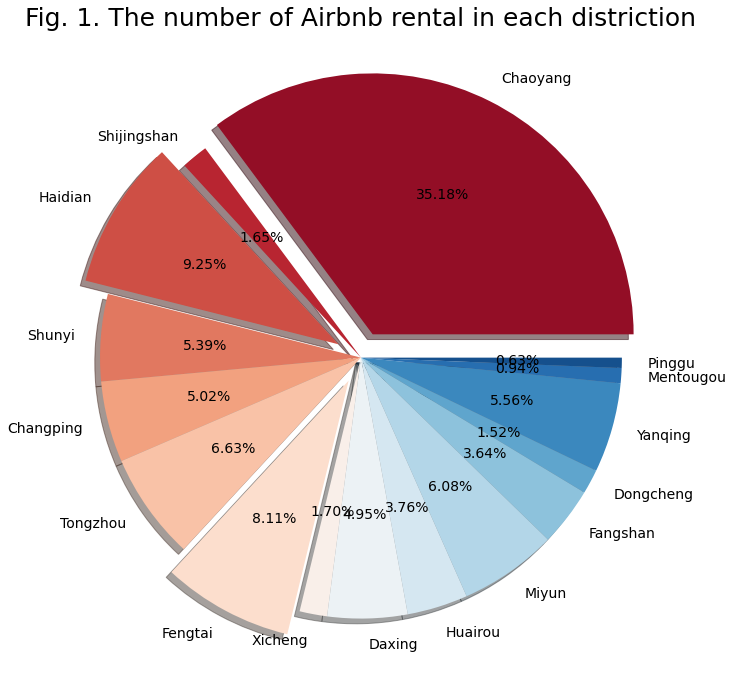

<ipython-input-9-724b333b0056>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_detailed.drop_duplicates(inplace=True)
<ipython-input-9-724b333b0056>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listings_detailed['neighbourhood_cleansed'] = listings_detailed['neighbourhood_cleansed'].apply(reshape_neigh)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


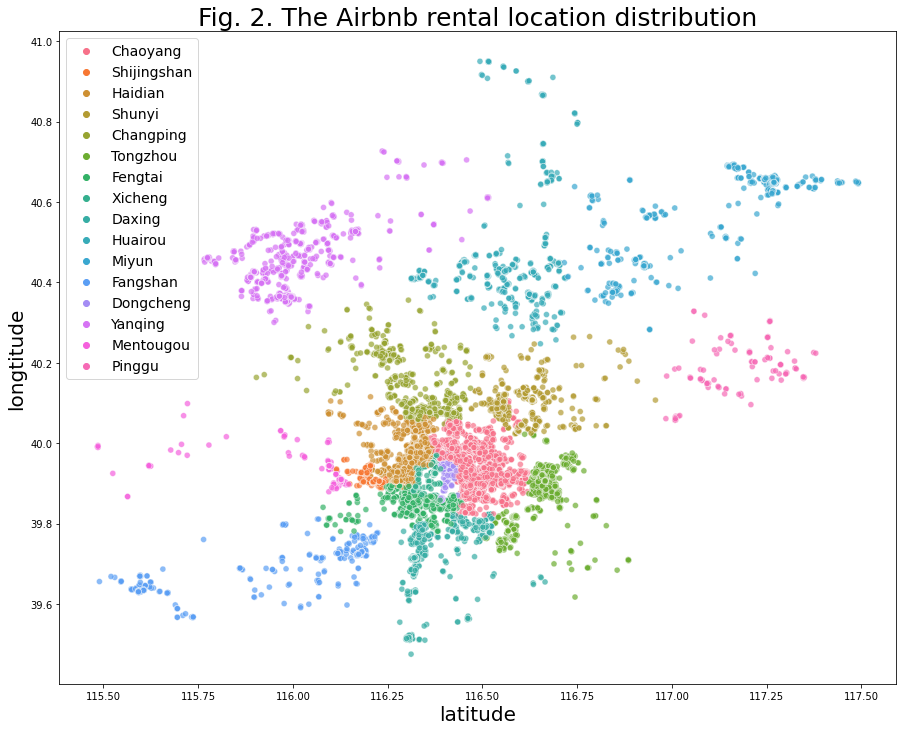

In [9]:

#Rental numbers in each area
res = listings_detailed.groupby('neighbourhood_cleansed')
area_list = listings_detailed['neighbourhood_cleansed'].to_list()
neighbour_counts = {}
for area in area_list:
    counts = res.get_group(area).shape[0]
    neighbour_counts[area] = counts

plt.figure(figsize = (12,12))
plt.title('Fig. 1. The number of Airbnb rental in each distriction', fontsize = 25)
label = [i[0] for i in neighbour_counts.items()]
data = [i[1] for i in neighbour_counts.items()]

max_area = sorted(neighbour_counts.items(), 
                  key = lambda x:x[1],
                  reverse = True)[:3]
max_area = [i[0] for i in max_area]

explode = [0.1 if i in max_area else 0 for i in label]
color = sns.color_palette("RdBu", len(label))
textprops = {"fontsize":14}
plt.pie(data, 
        labels = label, 
        shadow = True,
        explode = explode, 
        autopct = '%.2f%%', 
        colors = color,
        textprops = textprops)
plt.show()





#Rental geographical location distribution
listings_detailed.duplicated().sum()
listings_detailed.drop_duplicates(inplace=True)


def reshape_neigh(x):
    if len(x.split('/'))==1:
        x = x.strip()
    else:
        x = x.split('/')[0].strip()
    return x
listings_detailed['neighbourhood_cleansed'] = listings_detailed['neighbourhood_cleansed'].apply(reshape_neigh)


fig1, ax1 = plt.subplots(figsize = (15, 12))
ax1 = sns.scatterplot(
    x='longitude', 
    y='latitude', 
    hue='neighbourhood_cleansed', 
    data = listings_detailed, 
    alpha = 0.7)

ax1.set_title('Fig. 2. The Airbnb rental location distribution', fontsize = 25)

ax1.set_xlabel('latitude', fontsize = 20)
ax1.set_ylabel('longtitude', fontsize=20)
plt.legend(loc = 'best', fontsize = 14)

The pie chart illustrates the number of Airbnb rental distribution in each district in Beijing. Overall. over 55% of the rentals concentrate in Chaoyang District, Fengtai District, Haidian District, and Xicheng District, which means that their demand is higher than other areas. Furthermore, the rental distribution of other areas are even (approximately 5%-6%) except Pinggu and Mentougou District, accounting for only nearly 1%.

Fig. 2 prensents the overall rental house geographical location distribution in Beijing by latitude and longitude. In the location plot, we can see that the lower central areas (Fengtai, Xicheng, Daxing) contain more housing, and it is understandable that the central two districts in Beijing — West and East — are the historic districts, together with three near-ring-road districts (Hai Dian, Chao Yang, Feng Tai), where the rentals can be density (Li and Biljecki, 2019). In terms of Pinggu and Mentougou, those uncentralised areas are situated in distant locales, where the population can be dispersed.

###### 3.1.2 Rental amenities Wordle

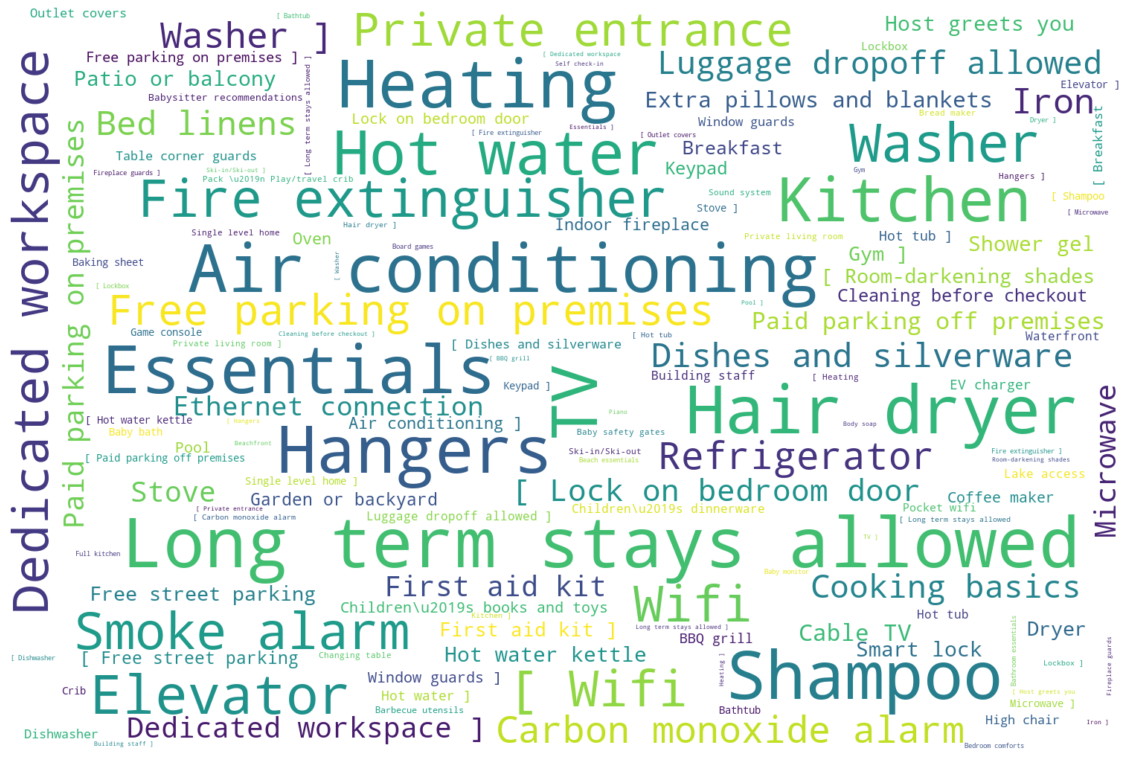

In [10]:

data = listings_detailed.copy()
data['amenities'] = data['amenities'].apply(lambda x: x.count(',') + 1)

a = listings_detailed['amenities'].apply(lambda x: pd.DataFrame(x.split(',')))
count = {}
for i in a:
    d = pd.DataFrame(i)
    word = d[0].apply(lambda x: re.sub('[""]', ' ', x))
    for j in word:
        if j in count.keys():
            count[j] = count[j] + 1
        else:
            count[j] = 1
            
def wc_from_word_count(word_count, fp):
    wc = WordCloud(
        max_words = 150,
        background_color = 'white',
        width = 1500,
        height = 1000,
        contour_width = 3,
        contour_color='black'
    )
    wc.generate_from_frequencies(word_count)
    ax = fig.add_subplot(1,1,1)
    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    wc.to_file(fp)

fig = plt.figure(figsize = (20, 20))
wc_from_word_count(count, '/Volumes/Ying/Salmon/UofG/Semester2/PTUA/Assignment/PythonA/Data/amenities_wordcloud.jpg')


The amenities Wordle illustrates the basic and entertained facilities/furniture in short staying rental. Overall, 'Wifi', 'Elevator', 'Dedicated workspace', 'Free parking on premises', and 'Fire extinguish' appear most frequently, which means that most tanents place more emphasis on the rental environment, safety and workable. In addtion, short staying rentals also provide long term stays offers, which means that it can be an altrenative or temporary choice for those tenants who are looking for a long term rental.

##### 3.1.3 Room type
**Number of room type**

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Count')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


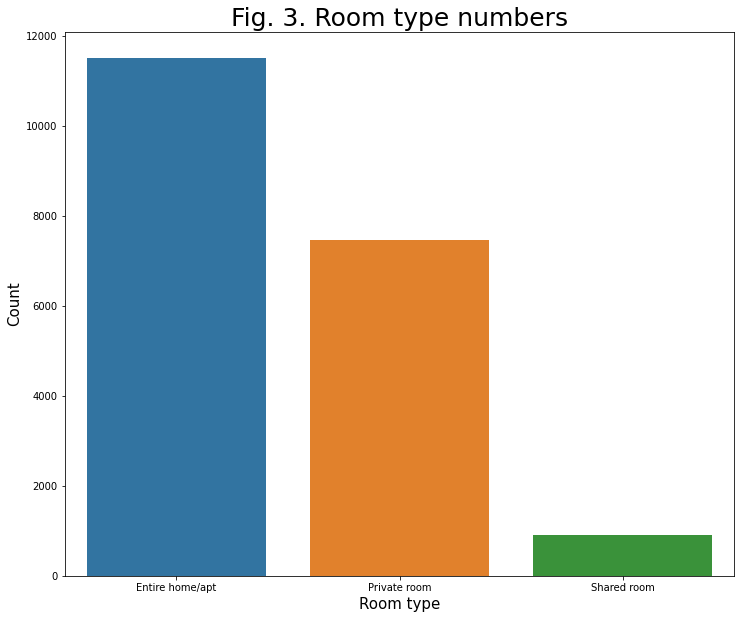

In [11]:
plt.figure(figsize=(12, 10))
sns.countplot('room_type', 
              data = listings_detailed)
plt.title('Fig. 3. Room type numbers', 
          fontsize = 25)
plt.xlabel('Room type', fontsize = 15)
plt.ylabel('Count', fontsize = 15)


We can see that there are three types of room in Airbnb rentals: Entire room, Private room, and Shared room. The entired room offers tenants accessing independent living rights, which is suitable to a family or high living reqirement consumers, but is most expensive one. The bar chart illustrates that entire room (about 11,800) is dominant and main stream among all room types, which is around 4,000 rooms more than Private room. On the onctrast, there are a few shared rooms (about 1,000) in Beijing, which means that the demands are lower than others. Most of these rooms are inn and dormitories, which are cheaper than others and suitable for backpackers or individual travellers.

**Room type number in each district**

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


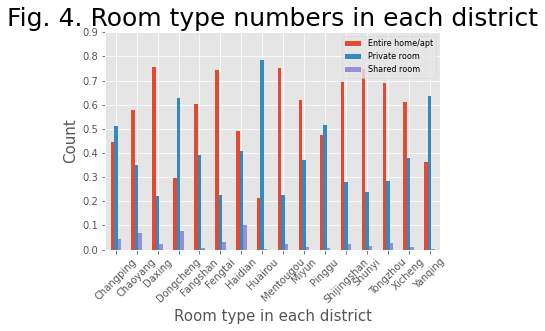

<Figure size 7200x1008 with 0 Axes>

In [12]:

plt.style.use('ggplot')

area_room = pd.crosstab(listings_detailed['neighbourhood_cleansed'], listings_detailed['room_type'])
area_room_std = area_room.div(area_room.sum(1), axis = 0)
area_room_std.plot.bar()

bar_width = 1
plt.title('Fig. 4. Room type numbers in each district', 
          fontsize = 25)
plt.xticks(rotation = 45)
plt.ylim(
    ymin = 0,
    ymax = 0.9)
plt.legend(
    loc = 'best', 
    fontsize = 8)
plt.xlabel('Room type in each district', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.figure(figsize = (100, 14))
plt.show()

In terms of each district, overall, most areas contain higher numbers of Entire room, except Changping (about 43%), Dongcheng (about 35%), Pinggu (about 43%), Huairou (about 20%), and Yanqing (about 38%). All the shared room proportion is the lowest one for each district, accounting for about lower than 10% for each one. Particularly, the three highest rental areas, Chaoyang, Dongcheng, and Fengtai, have different room type distribution. Interestingly, among these areas, Fengtai contains most Entire room, Dongcheng contains most Private room, but Chaoyang contains the highest number of Shared room, which means that tenants' room preference in these areas are diversified.

##### 3.1.4 Reviews mining
**Reviews and price**

Text(0, 0.5, 'Price')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


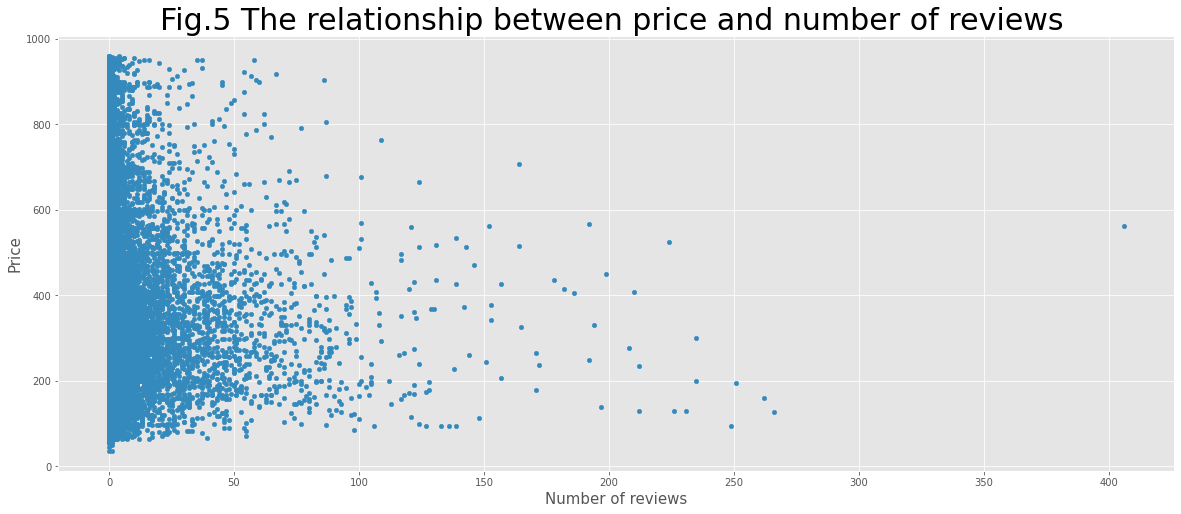

In [13]:

listings_detailed.plot.scatter(x = 'number_of_reviews', y = 'price', figsize = (20, 8))
plt.title('Fig.5 The relationship between price and number of reviews ', fontsize = 30)
plt.xlabel('Number of reviews', fontsize = 15)
plt.ylabel('Price', fontsize = 15)

The scatter plot illustrates the relationship between price and reviews. Overall, we can see that the price range of less reviews is larger than more number of reviews'. For 0 reviews, the price is dispersed from 0 (exclude) to 961 USD (include). There is an over 400 reviews rental in the right side of the plot and has only one around 600 USD rental price. In other words, the more reviews the rental has, the more stable price can be.

In [14]:

#Check the price preference between number of reviews and price
median1 = listings_detailed['number_of_reviews'].quantile(0.75)
median2 = listings_detailed['number_of_reviews'].quantile(0.25)

stf = listings_detailed[listings_detailed['number_of_reviews'] > median1]
nostf = listings_detailed[listings_detailed['number_of_reviews'] <= median2]

print('The average price of satisfied rental is: $' + str(round(stf['price'].mean(), )) + '.')
print('The average price of not very satisfied is: $'+ str(round(nostf['price'].mean(), )) + '.')

The average price of satisfied rental is: $357.
The average price of not very satisfied is: $393.


In [15]:
listings_detailed['price'].describe()

count   19874.00
mean      380.73
std       197.62
min        36.00
25%       237.00
50%       341.00
75%       498.00
max       961.00
Name: price, dtype: float64

In terms of reviews number analysis, we assume that higher number of comments is the criteria of a popular and high score rental. Thus, we set the number of Q3 comments (the number of comments higher than 75% of the number of overall comments) as 'good rental' and the Q1 numbers comments (the number of comments is lower than 25% of the number of overall comments) as 'not satisfied rental'. Comapred to the price description for total smaple, the price-filtered listings detailed data set (in section 3) makes sense. We can see that total average rental price is 380 USD, and the satisfied price is 357 USD and unsatisfied price is 393 USD, we can see that people's satisfied rental price is around but lower than average rental price.

**Comments Wordle**

With the development of technology, social media supports a great amount of user-generated content (UGC) on a wide range of platforms like vlogs, blogs. UGC is widely considered as an important resource to find out user experience and preference which can be references to understand user behaviour (Zhang and Fu, 2020). In this section, we use reviews_detailed data set for Wordle mining and explore the frequent experience of Airbnb renters.

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/hv/_s60g6qd1216c11dg_gqh_jm0000gn/T/jieba.cache
Loading model cost 0.502 seconds.
Prefix dict has been built successfully.


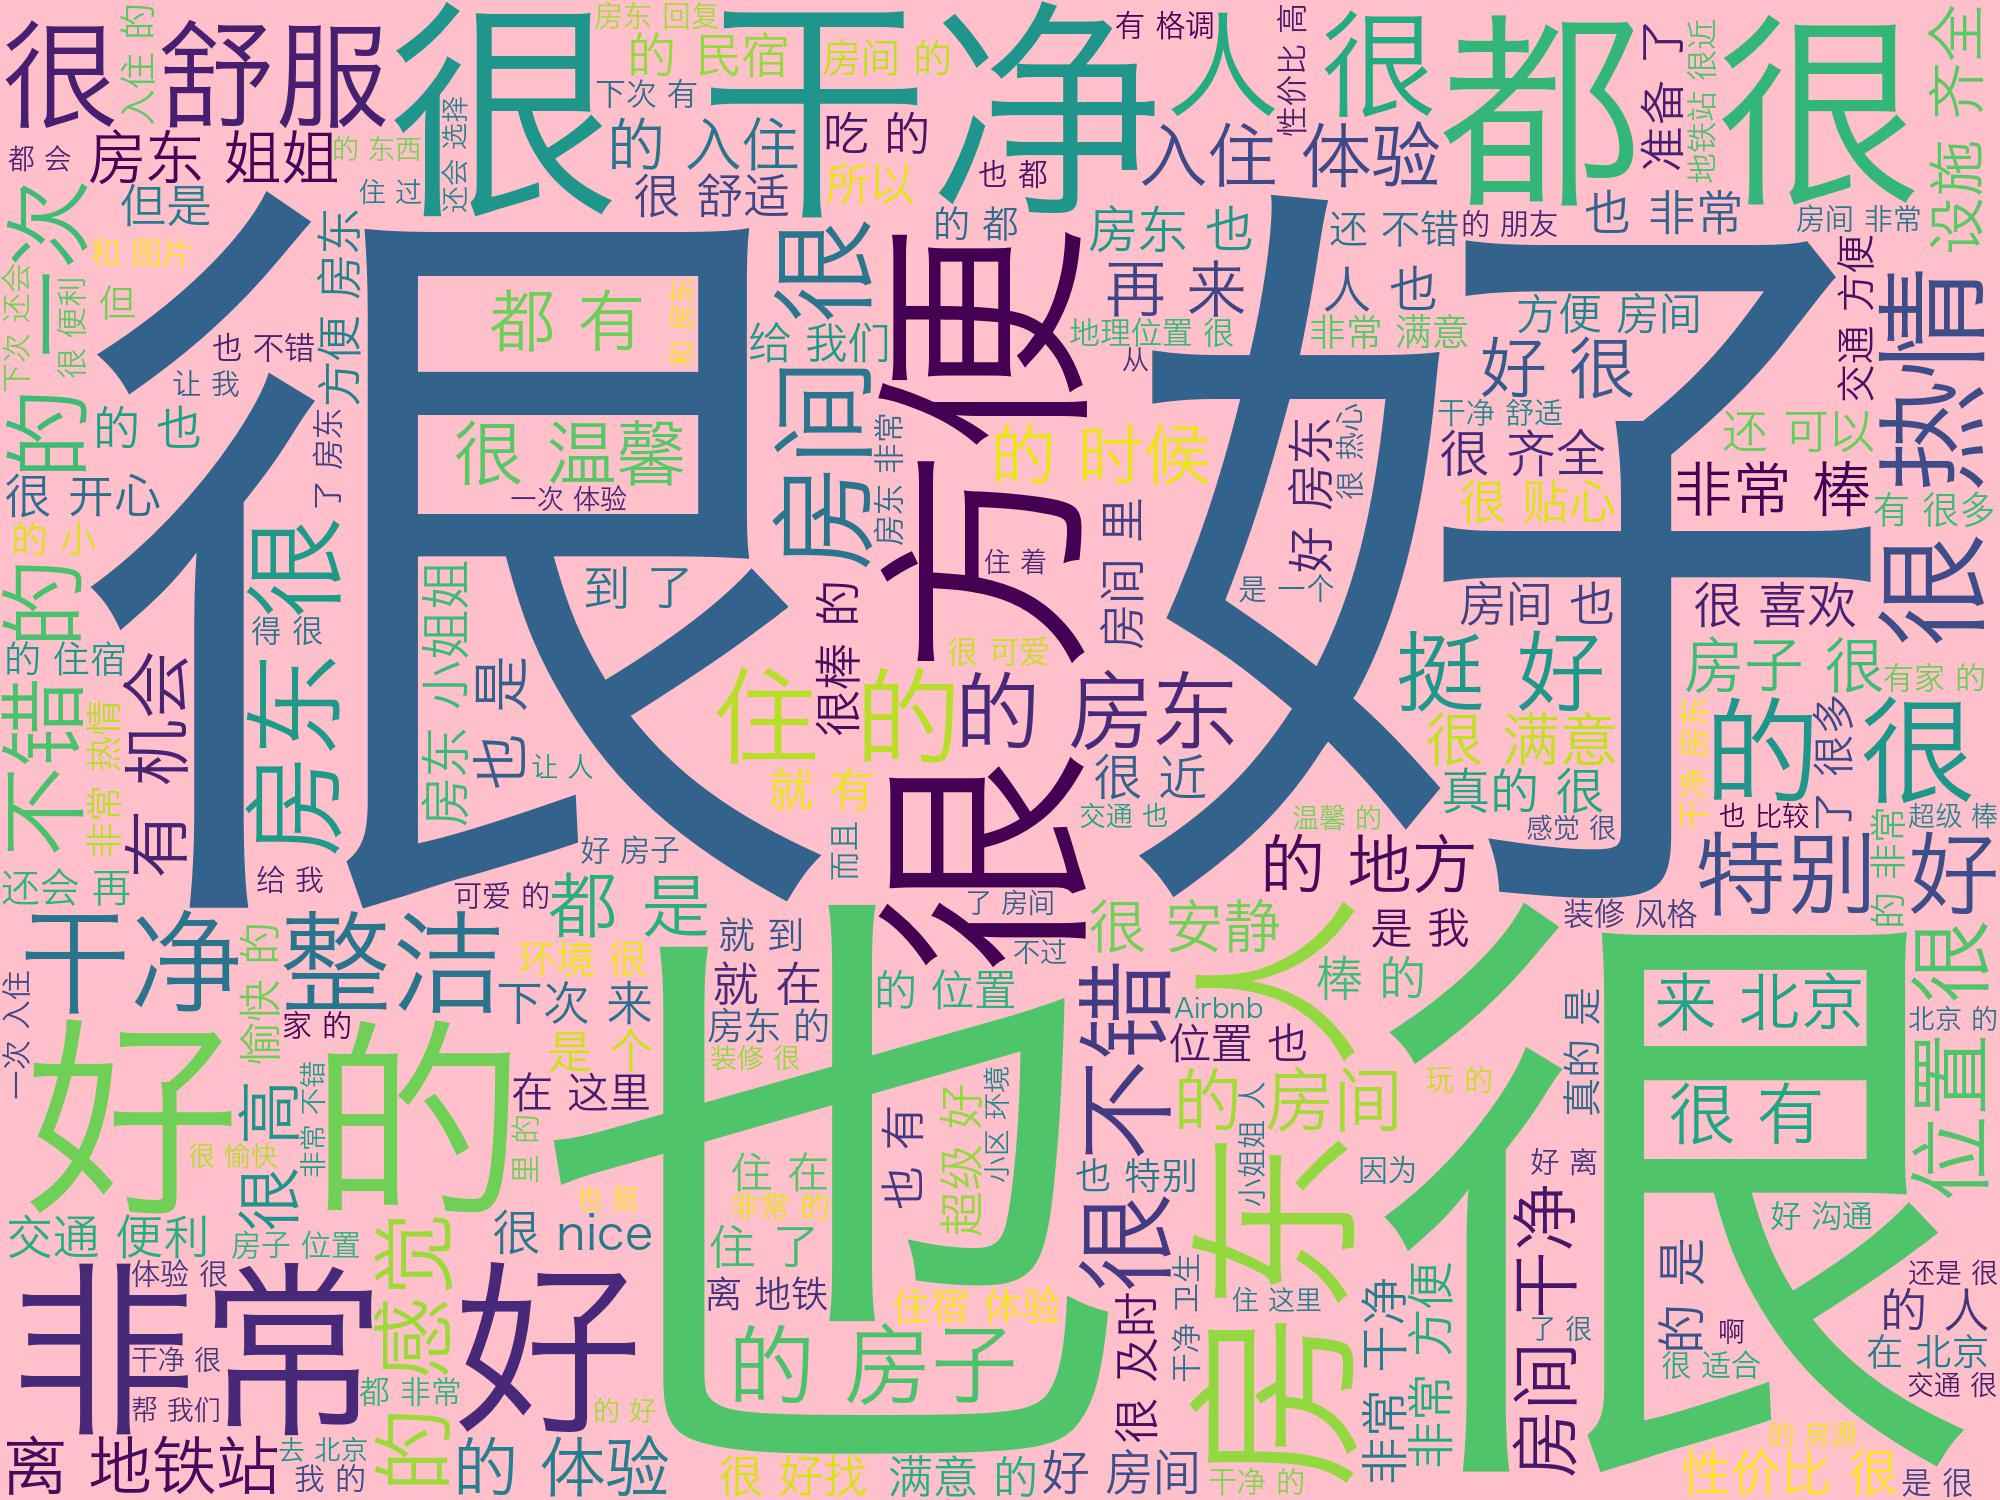

In [16]:

#import the review
reviews_detailed = pd.read_csv('/Volumes/Ying/Salmon/UofG/Semester2/PTUA/Assignment/PythonA/Data/Feb2021/reviews_detailed.csv')
reviews_detailed_df = pd.DataFrame(reviews_detailed)

#extract comments and transfer to strings
reviews_detailed_df_c = reviews_detailed_df['comments'].astype(str)

reviews_detailed_df_cc = []
for i in range(len(reviews_detailed_df_c)):
    if re.match(r'(.*[\u4E00-\u9FA5]+)|([\u4E00-\u9FA5]+.*)', reviews_detailed_df_c.loc[i]):
        reviews_detailed_df_cc.append(reviews_detailed_df_c.loc[i])

reviews_detailed_df_cc_1 = " ".join(reviews_detailed_df_cc)

#select the Chinese Character
cc_ret = jieba.lcut(reviews_detailed_df_cc_1)
cc_ret_1 = " ".join(cc_ret)

c_cloud = wordcloud.WordCloud(
    font_path = 'Hiragino Sans GB.ttc', 
    width = 2000,
    height = 1500,
    background_color = "pink",
    max_words = 200)
c_cloud.generate(cc_ret_1)
c_cloud.to_file('/Volumes/Ying/Salmon/UofG/Semester2/PTUA/Assignment/PythonA/Data/reviews_wordcloud.jpg')
Image('/Volumes/Ying/Salmon/UofG/Semester2/PTUA/Assignment/PythonA/Data/reviews_wordcloud.jpg')

The`Jieba` package is used for spliting Chinese characters, and `jieba.cut(s)` means that the sentence can be separated accuratly. The Wordle above presents people's comments to the short staying rental. Overall, most comments are positive such as '很好' (good, very satisfied, nice landlord). Particularly, '干净整洁' (clean and neat room), '位置方便' (good location and subway nearby), and '安静' (quiet) are most frequently comments. It reflects that public transport situated and delicated room inside quality rentals are popular to Beijing Airbnb users.

### 3.1.5 Price distribution

**Price bar chart and boxplot**

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Fig. 7. Room price in different district')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


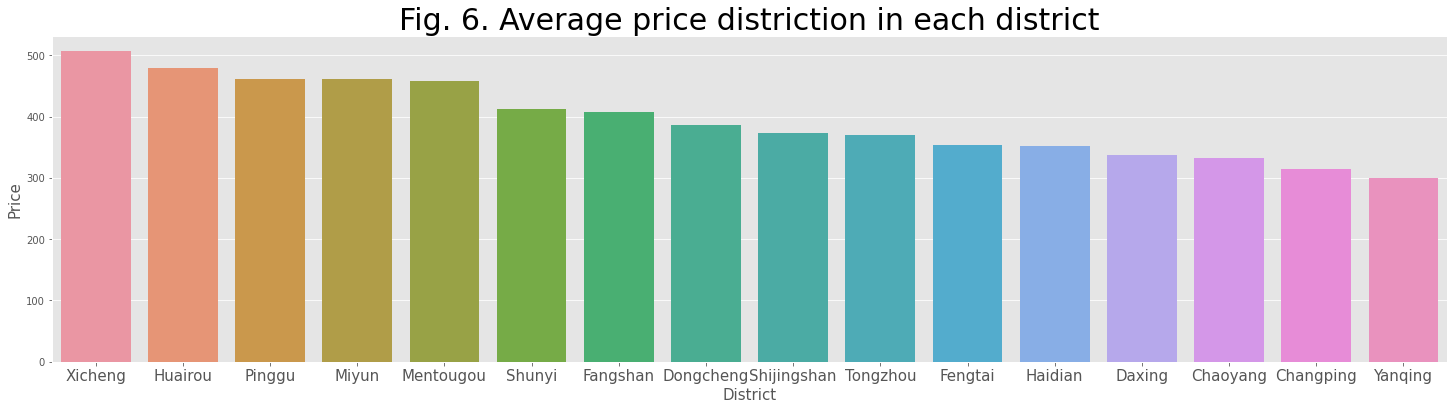

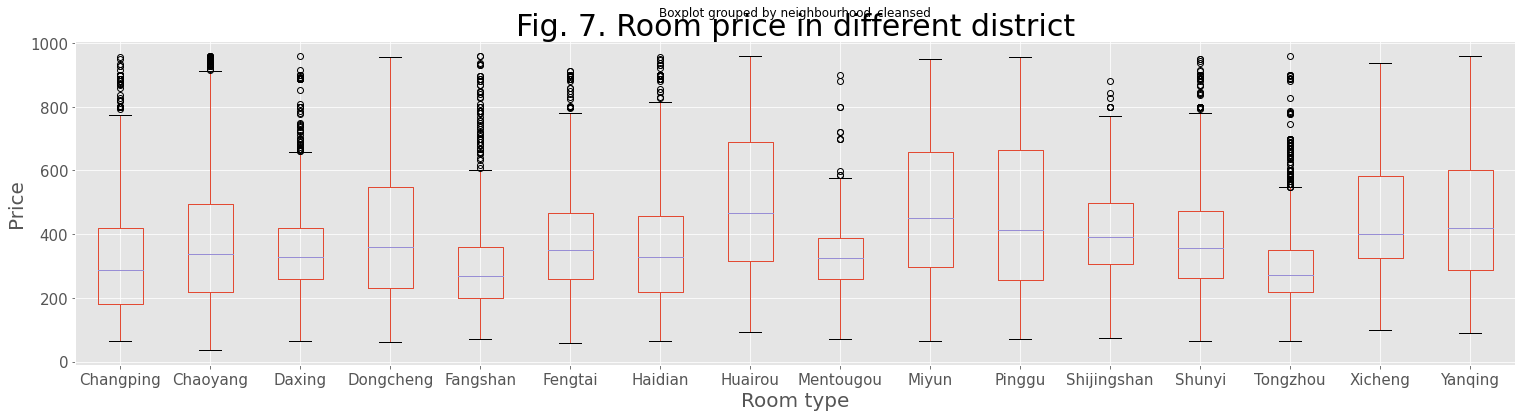

In [17]:

#Average price in each district
neighs = listings_detailed.neighbourhood_cleansed.unique()
price = pd.DataFrame(neighs, columns=['District'])
listings_detailed_ave_price = listings_detailed[['neighbourhood_cleansed', 'price']]
price['Average'] = listings_detailed_ave_price.groupby('neighbourhood_cleansed')['price'].mean().tolist()

#Price bar chart distribution in each district
fig, ax = plt.subplots(figsize=(25, 6))
ordered = price.sort_values(by='Average', ascending=False)
ax = sns.barplot(ordered['District'], ordered['Average'])
ax.set_title('Fig. 6. Average price distriction in each district', fontsize=30)
ax.set_xticklabels(ordered['District'], fontsize=15)
ax.set_xlabel('District', fontsize=15)
ax.set_ylabel('Price', fontsize=15)




#Price box plot distribution in each district
listings_detailed.boxplot(column = 'price', 
                          by = 'neighbourhood_cleansed', 
                          figsize = (25, 6),
                          fontsize = 15)
plt.ylabel('Price', fontsize = 20)
plt.xlabel('Room type', fontsize = 20)
plt.title('Fig. 7. Room price in different district', fontsize = 30)

Fig. 6. illustrates the average Airbnb rental price in each district from in the sequence of highest to lowest. Xicheng contains the most highest average rental price (accouting for about 510 USD per night), followed by Huairou, Pinggu, Miyun, and Mentougou, accounting for about 450 USD respectively. Yanqing and Changping hold the lowest price, accouting for about 300 USD. Interstingly, the average rental price of Chaoyang and Fengtai, two of the three most popular regions, is about150 USD lower than Xicheng. Similarly, some city centre regions such as Dongcheng (380 USD), the rental price are lower than distant regions, such as Shunyi (about 420 USD), Fangshan (about 410 USD), Miyun and so on.

On the contrary, Fig 7 may explain those interesting price difference phenomenons. Overall, the highest rental price in some distant regions, such as Huairou, Miyun, Pingfu, and Yanqing, are nearly 961 USD. The lowest price of those areas is all around 270 USD to 310 USD. Furthermore, most districts' median price is from 300 USD to 400 USD, except Huairou, Miyun, Pinggu, and Yanqing, which are all hogher than 400 USD. Besides, over 75% of the rental price in those areas is about 640 USD, this can explain the higher average rental price in these areas. In terms of the three most popular regions, Dongcheng involves the highest price (around 940 USD), and around 570 USD price accounts for 75% rentals. Followed by Chaoyang, around 75% rental price is around 500 USD, and the lowest price is around 210 USD. 

**Price Map**

In [18]:

world_map = folium.Map()
lati = 39.4
longti = 116.4
beijing_map = folium.Map(location = [lati, longti], zoom_start = 12)

sub_data = listings_detailed.sort_values(by = "price", ascending=False)
heat_data = sub_data.iloc[:1000][['latitude', 'longitude']].values.tolist()
HeatMap(heat_data).add_to(beijing_map)
beijing_map

The price heat map reflects the price distribution intuitively. Similar to the rental geographical location plot (Fig. 2.), the ring-inside districts, Chaoyang and Dongcheng, there are more rentals in these areas and the price is higher than other areas. Particularly, the price in Central Radio & Television Tower, Sanlitun and Beijing workers stadium, suituated in Chaoyang district and sourrounded by subway line 10, 8 and 6, is most intensive and the highest. Similarly, Gulou street (Dongcheng district), Qianmen (located next to the Forbidden City, Xicheng), and Universitiy clusters net (including Tsinghua, Peking Uni etc, Haidian) also present a densitive and higher price. It is easy to notice that the CBD regions, tertiary organisations, and tourist areas can be renter's first short staying housing choice. 

## 3.2 Machine learning
##### 3.2.1 Data Cleaning

In [19]:

#Check the missing ratio of each variable
listings_na = (listings_detailed.isnull().sum() / len(listings_detailed)) * 100
listings_na = listings_na.drop(listings_na[listings_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :listings_na})
missing_data.head()

,Missing Ratio
review_scores_location,45.21
review_scores_value,45.21
review_scores_checkin,45.21
review_scores_accuracy,45.19
review_scores_cleanliness,45.19


In [20]:

#Imput the missing values
listings_detailed = listings_detailed.drop((missing_data[missing_data['Missing Ratio'] > 0.4]).index,1)
listings_detailed = listings_detailed .fillna(0)

#Drop the missing data and check remaining missing values: there's no missing data missing
all_data_na = (listings_detailed.isnull().sum() / len(listings_detailed)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [21]:
listings_detailed.head(2)

,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,...,availability_30,availability_60,availability_90,availability_365,number_of_reviews,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms
0,f,5.00,t,t,Chaoyang,39.90,116.46,Entire apartment,Entire home/apt,2,...,30,60,90,365,57,t,5,5,0,0
1,f,5.00,t,t,Chaoyang,39.91,116.46,Entire apartment,Entire home/apt,2,...,2,2,2,2,12,t,5,5,0,0


##### 3.2.3 Correlation test
Multicollinearity is a state of very high intercorrelations or inter-associations among the independent variables. The correlation test is used to check the multicollinearity between each variables. Fig.4 presents that there is a strong relation between 'availability_30', 'availability_60', 'availability_90', and 'availability_365' (around 0.8). In this case, we can see that 'availability_365' contains other three variables, so we will only keep 'availability_365' for the machine learning model. Similarly, review_scores_rating, review_scores_checkin, and review_scores_location are highly correlated (around 0.75). We can see that availability 365 days contains 60 days, and the review socres can reflect the checkin score. Similarly, calculated_host_listings_count contains private room, entire room, and shared room. which can be counted as a perfect linear relations for those variables.


Text(0.5, 1.0, 'Fig. 8. Correlation heat map')

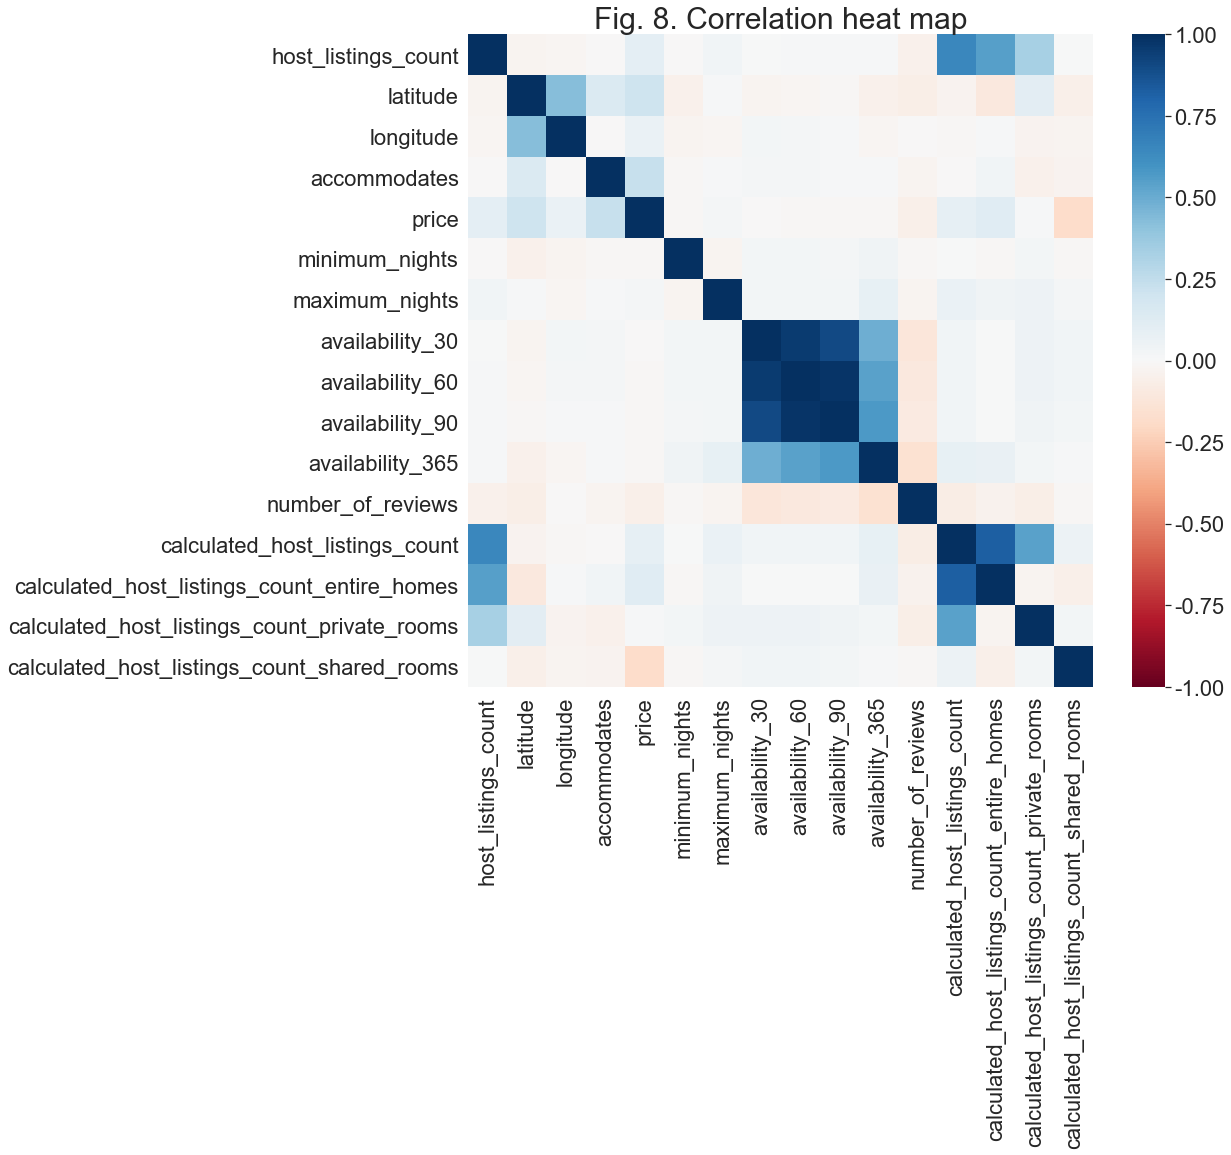

In [22]:
data = listings_detailed
corr_matrix = data.corr()
plt.figure(figsize = (14, 12))
sns.set(font_scale = 2)
sns.heatmap(corr_matrix, 
            vmin = -1, 
            vmax = 1, 
            cmap = sns.color_palette('RdBu', n_colors = corr_matrix.size))
plt.title('Fig. 8. Correlation heat map', fontsize = 30)

In [23]:
listings_detailed = listings_detailed.drop([
    'availability_30', 
    'availability_60', 
    'availability_90', 
    'host_listings_count',
    'calculated_host_listings_count_entire_homes',
    'calculated_host_listings_count_private_rooms',
    'calculated_host_listings_count_shared_rooms',
    'amenities'
], 
    axis = 1)

The heat map (Fig. 8) presents that there is a positive relation between latitude and rental price, which means the price of northern rentals is more expensive than the southern. In this case, we put 'price' in the first line and check the correlations between other independent vairables, and Fig. 9. presents that the rest variables all show a low correlation, the highest correlation is 0.42, and we can say that the those variables are appropriate for conducting regression models.

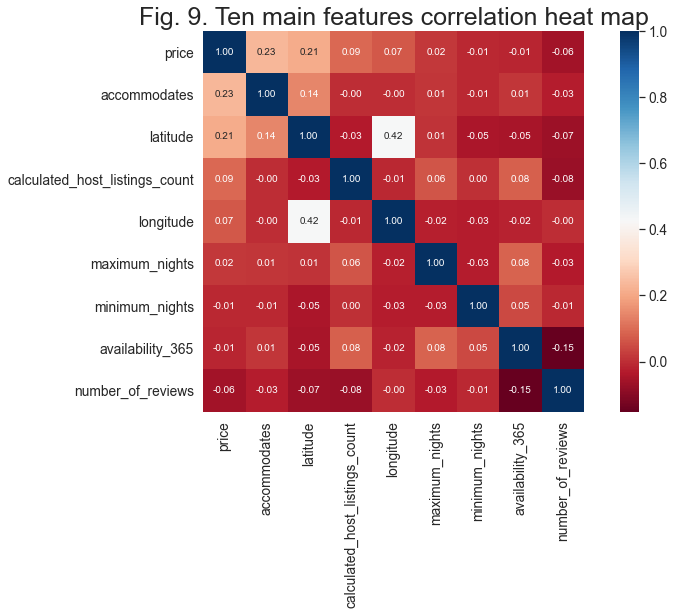

In [24]:

k = 10 
cols = listings_detailed.corr().nlargest(k, 'price')['price'].index
cm = listings_detailed[cols].corr()
sns.set(font_scale = 1.25)
plt.figure(figsize = (13, 7))
hm = sns.heatmap(
    cm, 
    cbar = True, 
    annot = True, 
    square = True, 
    fmt = '.2f', 
    annot_kws = {'size': 10}, 
    yticklabels = cols.values, 
    xticklabels = cols.values,
    cmap = sns.color_palette('RdBu', n_colors = data.corr().size)
)
plt.title('Fig. 9. Ten main features correlation heat map', fontsize = 25)
plt.show()


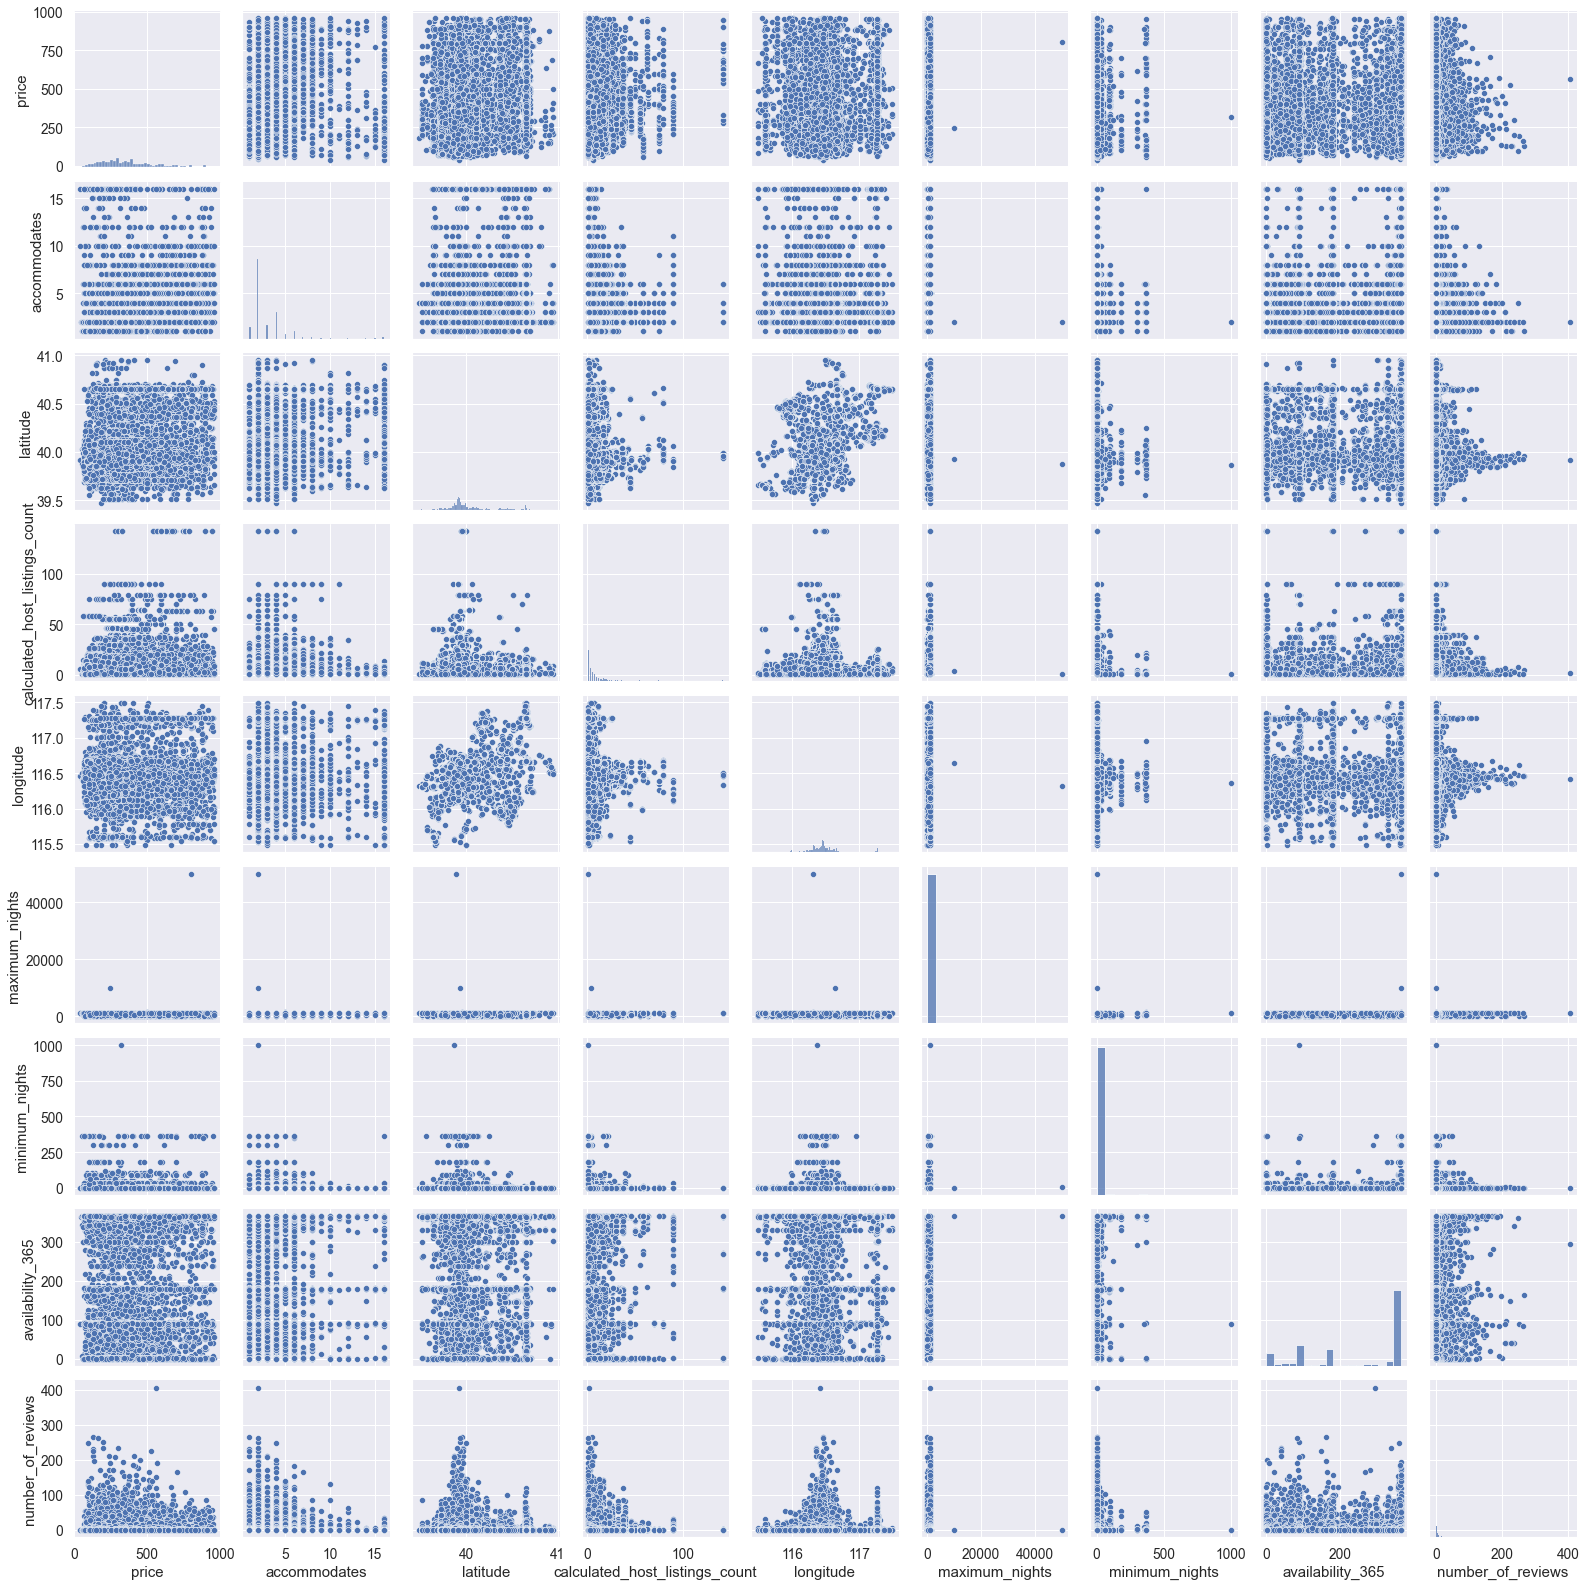

In [25]:
sns.pairplot(listings_detailed[cols], height = 2.5)
plt.show();

In [26]:
#check again the data size after dropping irrelevant variable
print("The total data size before dropping not irrelevant features is : {}".format(listings_data.shape))
print(f"The total data size after dropping other not irrelevant features is : {listings_detailed.shape} ")

The total data size before dropping not irrelevant features is : (24977, 74)
The total data size after dropping other not irrelevant features is : (19874, 18) 


##### 3.2.4 Normality check
'price' is the target variable (or dependent variable) for machine learning. We check its normality The log() price distribution skew shows that the data appears more normally distributed (Fig. 10).

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 1800x432 with 0 Axes>

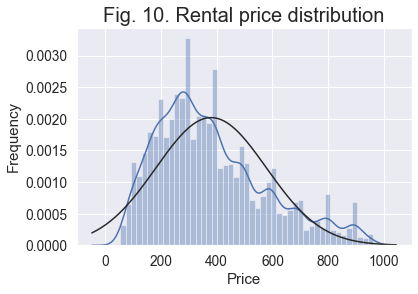

<Figure size 1800x432 with 0 Axes>

In [27]:

sns.distplot(listings_detailed['price'], fit = norm)
plt.ylabel('Frequency', fontsize = 15)
plt.xlabel('Price', fontsize = 15)
plt.title('Fig. 10. Rental price distribution', fontsize = 20)
plt.figure(figsize=(25, 6)) 

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 1800x432 with 0 Axes>

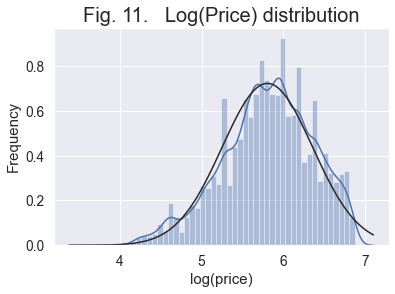

<Figure size 1800x432 with 0 Axes>

In [28]:

data1 = listings_detailed
data1["price"] = np.log1p(data1["price"])

#Check the new distribution 
sns.distplot(data1['price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(data1['price'])


plt.ylabel('Frequency', fontsize = 15)
plt.xlabel('log(price)', fontsize = 15)
plt.title('Fig. 11.   Log(Price) distribution', fontsize = 20)
plt.figure(figsize=(25, 6)) 

##### 3.2.5 Feature engineering
##### Data transformation
We encode and transfer categorical variables to vector, take 'neighbourhood_cleansed' as an example, 0 means the place here is not a neighboorhood and vice versa. Then, we split train data set and test data set from sklearn.model_selection pacakge. The final total data set contains 19,887 observations and 186 processed (transformed) independent variables, and the train data set contains 185 independent variables and 14,915 obervations and test set contains 4,972 and 185 respectively. We choose median price (0.55 USD) as the baseline and can be used as a reference to check the model fitness.

In [29]:
#Get the dummy variables for each none numeric variable
data = listings_detailed 
data = pd.get_dummies(data)
data.head(5)

,latitude,longitude,accommodates,price,minimum_nights,maximum_nights,availability_365,number_of_reviews,calculated_host_listings_count,host_is_superhost_0,...,bathrooms_text_8.5 baths,bathrooms_text_9 baths,bathrooms_text_9 shared baths,bathrooms_text_9.5 baths,bathrooms_text_Half-bath,bathrooms_text_Private half-bath,bathrooms_text_Shared half-bath,has_availability_t,instant_bookable_f,instant_bookable_t
0,39.90,116.46,2,6.40,1,730,365,57,5,0,...,0,0,0,0,0,0,0,1,0,1
1,39.91,116.46,2,6.51,1,1125,2,12,5,0,...,0,0,0,0,0,0,0,1,0,1
3,39.90,116.48,2,6.06,1,1125,365,7,9,0,...,0,0,0,0,0,0,0,1,1,0
4,39.90,116.48,2,6.19,1,1125,2,2,9,0,...,0,0,0,0,0,0,0,1,1,0
5,39.99,116.50,1,5.56,2,1125,1,23,2,0,...,0,0,0,0,0,0,1,1,1,0


In [30]:

#set train and test data set
x = data.copy().drop('price', axis = 1)
y = data['price'].copy()
x_train, x_test, y_train, y_test = train_test_split(x, y)

#check the total data set number of observation and variables
data.shape

(19874, 186)

In [31]:

#scale and split the train and test data set
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)
print(f"\nThe train data size is : {x_train.shape} ")
print(f"The test data size is : {x_test.shape} ")


The train data size is : (14905, 185) 
The test data size is : (4969, 185) 


##### Baseline

In [32]:
baseline = y_train.median()
baseline_error = np.sqrt(mean_squared_error(
    y_pred = np.ones_like(y_test)*baseline,
    y_true = y_test))
round(baseline_error, 3)

0.559

##### 3.2.6 Modelling
To model the relationship between rental prices and property proximity to certain venues based on Airbnb data, we use Multiple Linear Regression, Lasso Regression, and Ridge Regression model for the price prediction machine learning. We try all alpha and l1ratios for each model to get the best results. 

In [33]:

lr = LinearRegression()
alphas = [1000, 100, 50, 20, 10, 1, 0.1, 0.01]
l1_ratios = [0.001, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9]

ridge = RidgeCV(alphas = alphas)

lasso = LassoCV(
    alphas = alphas, 
    max_iter = 10000)

elastic = ElasticNetCV(
    alphas = alphas,
    l1_ratio = l1_ratios)




for model, name in zip([lr, ridge, lasso, elastic], ['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet']):
    model.fit(x_train_scaled, y_train)
    y_pred_train = model.predict(x_train_scaled)
    rmse_train = np.sqrt(mean_squared_error(y_pred = y_pred_train, y_true = y_train))
    y_pred = model.predict(x_test_scaled)
    rmse_test = np.sqrt(mean_squared_error(y_pred = y_pred, y_true = y_test))
    best_alpha = ' '
    if name != 'LinearRegression':
        best_alpha = 'best alpha: ' + str(model.alpha_)
    best_l1 = ' '
    if name == 'ElasticNet':
        best_l1 = 'best l1:' + str(model.l1_ratio_)
    print(name + ': rmse_train:' + str(rmse_train) + 
          ', rmse_test: ' + str(rmse_test) + ', ' + best_alpha + ', ' + best_l1)

LinearRegression: rmse_train:0.4219246882359241, rmse_test: 145615205112.0328,  ,  
Ridge: rmse_train:0.42278045855148705, rmse_test: 0.4293639869399423, best alpha: 1000.0,  
Lasso: rmse_train:0.4331657969298741, rmse_test: 0.43558236043928716, best alpha: 0.01,  
ElasticNet: rmse_train:0.42417101756112935, rmse_test: 0.4286696706140681, best alpha: 0.01, best l1:0.3


RMSE indicates the sum of the squared errors in the model's predictions and suggests the model's predictive capabilities. In this case, we can say that train data errors are reasonable to understand how it generalises and performs data that did not use for training before. From the model results, the RMSE values should come out to be approximately 0.559. In terms of Linear Regression model, the train error is around ± 0.422 USD, where the test erroer is worse (over 90 billion). This can be interpreted that LR overflows and does not convert many variables. For Ridge Regression model, the outcomes make more sense that the errors are about 0.423 and 0.429 for train and test respectively, and the best alpha is 1000. ElasticNet model is similar, all errors are around 0.424 and 0.429 respectively, and the best alpha is 0.01, best l1 ratio is 0.1. For Lasso, the rmse is the closest compared to the baseline (0.559), and the train and test rmse is 0.433 and 0.436 respectively. Besides, Lasso Regression model removed some more irrelevant variables, thus we conclude say that Lasso performs the best among other models.

##### 3.2.7 Error analysis
The error analysis can present the difference between estimation and acutal sample values. We choose Lasso regression model for the error analysis. Fig. 12. shows that the error distribution of Elastic model. We can see that most estimations are around 0, however, there are still several unaccurate predictions surpass the true values from 1 to 2, which can be the reason that makes the average error large. 

Text(0.5, 1.0, 'Fig. 12.  Lasso Regression test error distribution')

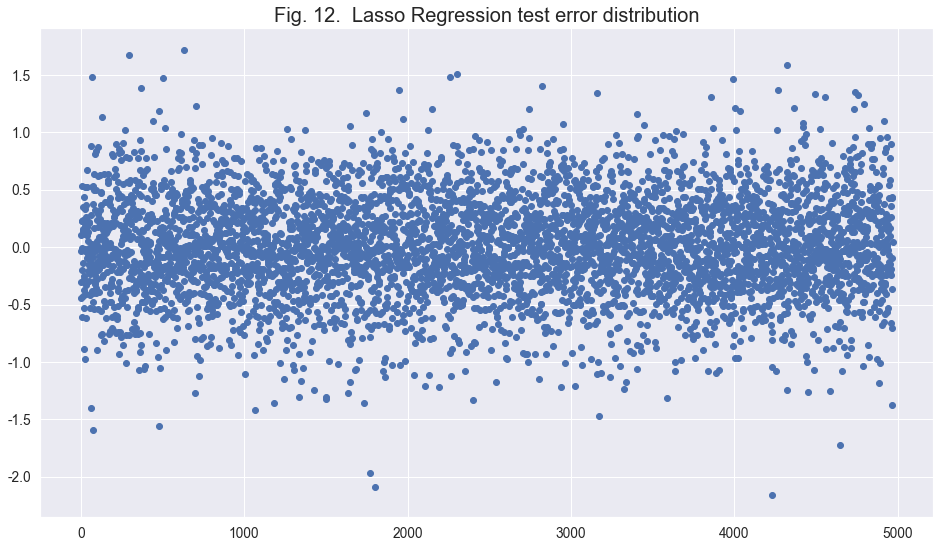

In [34]:
y_pred_test = lasso.predict(x_test_scaled)
di = y_test - y_pred_test
plt.figure(figsize = (16, 9))
plt.scatter(np.arange(len(di)), di)
plt.title('Fig. 12.  Lasso Regression test error distribution', fontsize = 20)

<br>

## 4. Summary
### 4.1 Main findings
This report presents the Airbnb data analysis in Beijing (China), with focus on exploratory data anaylsis on locations, room types, and price. To the end, we employ Lasso, ElasticNet, Ridge, and Linear regression methods for price data prediction.

The EDA reveals the relationship differences of price between rental location, review numbers, and room type and raises the question whether price are driven by the same features. The results show that the city centre areas, Dongcheng, Fengtai, Chaoyang, and  Xicheng, have most number of rentals and centralized price. The room type analysis suggests that most people prefer entire room/apartment in total (Voltes-Dorta and Sánchez-Medina, 2020), and some of those city centre tenants would choose private rooms. What's more, the Wordle of amenities and comments present that Airbnb renters perfer well-structured transportation system located rentals and high living quality rooms. Finally, the rental price is focusing on tourists areas, university areas, and some CBD regions.

The machine leanrning present the price influencing factors analysis and the prediction model fitness. In terms of the relevant factors analysis, we can see that accomodation and latitude have higher positve relations with price, whereas the minimum available nights and number of reivews show a negative influence, which means that the more reviews and nights the rental have, the lower of the rental price can be, in other words, it can be more difficult to landlord to assign an appropriate price. The modelling section uses Lasso, Ridge, LR, and Elastic models for price prediction and the results show that Lasso Regression has the best performance (with 0.436 RMSE value) and can be explained due to the omits of some irrelevant variables.

### 4.2 Suggestions
Overall, the models and EDA imply resonable results of price and each key features and most findings are consistent with previous research. However, there are still some research gaps for this report. Firstly, some distant areas, such as Pinggu, Huairou have highest rental price, there is no significant evidence that supports the exorbitant rental price and this needs further exploration. Secondly, the date set is web-scraped type and can have many limitations, it may contain too many unrecognized information, in this case, we can see that we drop over 45 variables out of 74 variables, and over 20 variables are NA or repeated or irrelevant text variables. This may have some influence on our modelling fitness as our number of variables may not be comprehensive enough. Thus, we can optimise the web scraping method to get more accurate data set.

<br>

## References
Airbnb. Fast Facts. Available online: https://press.airbnb.com/fast-facts/ (accessed on 11 June 2019).<br><br>
Belarmino, A., Whalen, E., Koh, Y. and Bowen, J., 2017. Comparing guests’ key attributes of peer-to-peer accommodations and hotels: mixed-methods approach. *Current Issues in Tourism*, **22**(1), pp. 1-7.<br><br>
Hoaglin, D. and Tukey, J., 2000. *Understanding robust and exploratory data analysis*. New York [i 5 pozostałych]: John Wiley & Sons.<br><br>
Inside Airbnb (2021), Adding data to the debates: (http://insideairbnb.com/get-the-data.html) [accessed 01/03/2021]<br><br>
Li, J. and Biljecki, F., 2019. THE IMPLEMENTATION OF BIG DATA ANALYSIS IN REGULATING ONLINE SHORT-TERM RENTAL BUSINESS: A CASE OF AIRBNB IN BEIJING. ISPRS Annals of Photogrammetry, **Remote Sensing and Spatial Information Sciences**, IV-4/W9, pp. 79-86.<br><br>
Voltes-Dorta, A. and Sánchez-Medina, A., 2020. Drivers of Airbnb prices according to property/room type, season and location: A regression approach. *Journal of Hospitality and Tourism Management*, **45**, pp. 266-275. <br><br>
Zhang, Z. and Fu, R., 2020. Accommodation Experience in the Sharing Economy: A Comparative Study of Airbnb Online Reviews. *Sustainability*, **12**(24), p. 10500.<br><br>


In [35]:

import io
import os
from nbformat import current

total_markdown = 0
total_heading = 0
total_code = 0

for root, dirs, files in os.walk("."):
    for file in files:
        if file.endswith(".ipynb") and not file.endswith("checkpoint.ipynb") :
            print(os.path.join(root, file))
            with io.open(os.path.join(root, file), 'r', encoding='utf-8') as f:
                nb = current.read(f, 'json')

            word_count_markdown = 0
            word_count_heading = 0
            word_count_code = 0
            for cell in nb.worksheets[0].cells:
                if cell.cell_type == "markdown":
                    word_count_markdown += len(cell['source'].replace('#', '').lstrip().split(' '))
                elif cell.cell_type == "heading":
                    word_count_heading += len(cell['source'].replace('#', '').lstrip().split(' '))
                elif cell.cell_type == "code":
                    word_count_code += len(cell['input'].replace('#', '').lstrip().split(' '))
            total_markdown += word_count_markdown
            total_heading += word_count_heading
            total_code += word_count_code
            print("{} Words in notebooks' markdown" .format(word_count_markdown))
            print("{} Words in notebooks' heading" .format(word_count_heading))
            print("{} Words in notebooks' code" .format(word_count_code))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/nbformat/current.py:15: UserWarning: nbformat.current is deprecated.

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  warnings.warn("""nbformat.current is deprecated.


./2516202_URBAN5123.ipynb
3290 Words in notebooks' markdown
11 Words in notebooks' heading
2387 Words in notebooks' code
